In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import scipy.stats as st
import os
import math
from math import sqrt 
import heapq
from scipy import stats
from scipy.stats import t, sem
from tqdm import tqdm
from statsmodels.stats.power import TTestIndPower 
from itertools import combinations

In [ ]:
COLORS = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'brown', 'orange']
SAVE_DIR = 'media'
os.makedirs(SAVE_DIR, exist_ok=True)
RANDOM_SEED = 42

# Defaults
N_SIM = 100
N_CUSTOMERS = 200
ARRIVAL_INTERVAL = 10.0
SERVICE_TIME = 12.0

# Queueing Theory: M/M/2 vs M/M/1 Queues

Using the Erlang C Formula (A. Willig, 1999), which calculates the probability of queuing, we can analyze and compare the average waiting times in M/M/2 and M/M/1 queue models.

## M/M/N Queue

### Erlang C Formula
The Erlang C formula for an M/M/N queue is given by:
$$ P_w = \frac{\frac{(\rho \cdot N)^N}{N!} \cdot \frac{1}{1 - \rho}}{\sum_{k=0}^{1} \frac{(\rho \cdot 2)^k}{k!} + \frac{(\rho \cdot N)^N}{N!} \cdot \frac{1}{1 - \rho}} $$

### Average Waiting Time in Queue
$$ W_q = \frac{P_w}{N\mu - \lambda} $$


By comparing these two models, we can gain insights into how the number of servers in a queuing system affects the average waiting time and overall system efficiency.

In [ ]:
def erlangC(n, rho):
    """
    Calculate the Erlang C formula for a given number of servers and system load.

    The Erlang C formula is used in queue theory to determine the probability 
    that an arriving customer has to wait for service in an M/M/n queue.

    Parameters:
    n (int): The number of servers in the system.
    rho (float): The system load

    Returns:
    float: The probability of having to wait for service in the queue.
    """
    numerator = (rho**n / math.factorial(n)) * (1 / (1 - rho))
    denominator = sum([(rho**k) / math.factorial(k) for k in range(n)]) + numerator
    return numerator / denominator

def mxn_queue(lambda_rate, mu, n):
    """
    This function computes the average waiting time in the queue for a multi-server queue model.

    Parameters:
    lambda_rate (float): The arrival rate into the system.
    mu (float): The service rate of each individual server.
    n (int): The number of servers in the queue system.

    Returns:
    A float containing the average waiting time in the queue (Wq).
    """
    rho = lambda_rate / (n * mu) 
    Pw = erlangC(n, rho)
    Wq = Pw / (n * mu - lambda_rate) 
    return Wq

In [ ]:
# Parameters
mu = 1
ns = [1, 2, 3, 4, 5, 6]
lambda_rates = np.linspace(0.1, mu, 100)

plt.figure(figsize=(6, 4))
for n in ns:
    waiting_times = [mxn_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]
    plt.plot(lambda_rates, waiting_times, label=f'M/M/{n}')
plt.xlabel('$p$ system load')
plt.ylabel('Average waiting time')
plt.yscale('log')
plt.title(f'Average waiting time vs system load for various M/M/n queues')
plt.legend()
plt.grid(True)
plt.show()

### 2.
Using https://simpy.readthedocs.io/en/latest/examples/bank_renege.html tutorial code as base

In [ ]:
def source(env, cst_total, arrival_interval, counters, store_wait_times, arrival_pdf='exp', service_pdf='exp', service_time=SERVICE_TIME):
    """
    Generates customers at random intervals and initiates their service process.

    Parameters:
    env (simpy.Environment): The simulation environment.
    cst_total (int): The total number of customers to be generated in the simulation.
    arrival_interval (float): The average time interval between the arrivals of customers.
    counters (simpy.Resource): The service counter or resource to be used by customers.
    store_wait_times (list): A list to record the waiting times of each customer.
    arrival_pdf (str): The probability distribution function for customer arrival intervals. 
                       Options are 'exp' for exponential and 'const' for constant intervals.
    service_pdf (str): The probability distribution function for customer service times.
                       Options are 'exp' for exponential, 'const' for constant, and 'hyperexp' for hyperexponential.
    service_time (float): The average service time, used in service time calculations.

    Raises:
    ValueError: If an invalid distribution type is provided for either arrival or service intervals.
    """
    for i in range(cst_total):
        c = customer(env, f'Customer{i:02d}', counters, store_wait_times, service_pdf=service_pdf, service_time=service_time)
        env.process(c)
        if arrival_pdf == 'exp':
            t = random.expovariate(1.0 / arrival_interval)
        elif arrival_pdf == 'const':
            t = arrival_interval
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(t)

def customer(env, name, counters, store_wait_times, service_pdf='exp', service_time=SERVICE_TIME):   
    """
    Represents a customer arriving, being served, and leaving.

    This function models the behavior of a customer in the queue. It records the waiting time
    and the service time, depending on the specified distribution type for service.

    Parameters:
    env (simpy.Environment): The simulation environment.
    name (str): The name/id of the customer.
    counters (simpy.Resource): The service counter or resource being used by the customer.
    store_wait_times (list): A list to record the waiting time of the customer.
    service_pdf (str): The type of distribution for the service time ('exp' for exponential, 
                       'const' for constant, 'hyperexp' for hyperexponential).
    service_time (float): The average or base service time, used in service time calculations.
    hyperexp_p (float): The probability parameter used in the hyperexponential distribution, 
                        representing the probability of having a short service time.
    hyperexp_factor (float): A multiplier used to determine the longer service time in the hyperexponential distribution.

    Raises:
    ValueError: If an invalid distribution type is provided for service time.
    """
    arrive = env.now
    with counters.request() as req:
        yield req 
        wait = env.now - arrive
        if service_pdf == 'exp':
            service_time = random.expovariate(1.0 / service_time) 
        elif service_pdf == 'const':
            service_time = service_time
        elif service_pdf == 'hyperexp':
            np.random.choice([random.expovariate(1.0 / (1/3 * service_time)), random.expovariate(1.0 / (3 * service_time))], p=[0.75, 0.25])
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(service_time)
        store_wait_times.append(wait)

def simulate_experiments_by_ns(arrival_pdf='exp', service_pdf='exp', ns=[1, 2, 4], n_sim=N_SIM):
    """Run the simulations with provided parameters and return the waiting times and their averages"""
    data_wait_times = {n: [] for n in ns}
    means = {n: [] for n in ns}
    for n in ns:
        for i in range(n_sim):
            random.seed(RANDOM_SEED+i)
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counter, wait_times, arrival_pdf=arrival_pdf, service_pdf=service_pdf))
            env.run()
            data_wait_times[n].append(wait_times)
            means[n].append(np.mean(wait_times))
    return data_wait_times, means


def get_statistics(wait_times_data, ci=0.95, print_results=True):
    """Calculate average, standard deviation, and confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(ci, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, mean waiting time: {avg_wait_time:.2f}, std dev: {std_dev:.2f}, {ci*100}% CI ({c_low:.2e} | {c_high:.2e})')
    return avgs, stds, conf_intervals

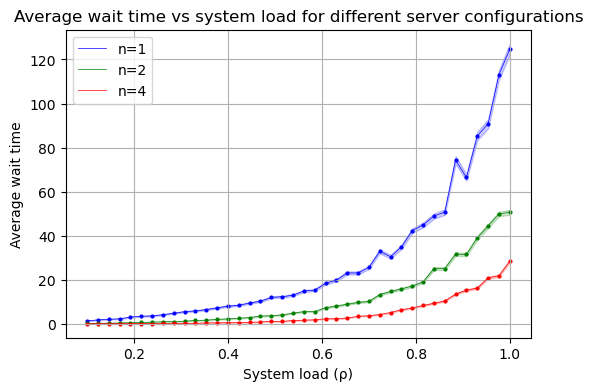

In [39]:
def simulate_experiments_by_rhos(n, rhos, mu, sim_time, n_sim, ci=0.95):
    results = []
    for rho in rhos:
        lambda_rate = rho * n * mu  
        wait_times_aggregate = []
        for _ in range(n_sim):
            env = simpy.Environment()
            wait_times = []
            env.process(source(env, N_CUSTOMERS, 1/lambda_rate, simpy.Resource(env, capacity=n), wait_times))
            env.run(until=sim_time)
            wait_times_aggregate.extend(wait_times)
        avg_wait = np.mean(wait_times_aggregate)
        std_dev = np.std(wait_times_aggregate)
        conf_interval = st.t.interval(ci, len(wait_times_aggregate)-1, loc=avg_wait, scale=st.sem(wait_times_aggregate))
        results.append((rho, avg_wait, std_dev, conf_interval, wait_times_aggregate))
    return results

def power_analysis_by_ns(rhos, mu, sim_time, n_sim, pairs, alpha=0.003, power=0.9, print_out=True):
    results = {n: [] for n in ns}
    avg_wait_times = {n: [] for n in ns}
    wait_times_aggregate = {n: [] for n in ns}
    conf_intervals = {n: [] for n in ns}
    stds = {n: [] for n in ns}

    for n in ns:
        results[n] = simulate_experiments_by_rhos(n, rhos, mu, sim_time, n_sim)
        avg_wait_times[n] = [result[1] for result in results[n]]
        conf_intervals[n] = [result[3] for result in results[n]]
        stds[n] = [result[2] for result in results[n]]
        wait_times_aggregate[n] = [result[4] for result in results[n]]

    ns_needed = []

    for pair in pairs:
        for i, rho in enumerate(rhos):
            n_serv1, n_serv2 = pair
            n1, n2 = len(wait_times_aggregate[n_serv1][i]), len(wait_times_aggregate[n_serv2][i])
            std_1, std2 = stds[n_serv1][i], stds[n_serv2][i]
            s_pooled_std = sqrt(((n1 - 1) * std_1 ** 2 + (n2 - 1) * std2 ** 2) /  
                    (n1 + n2 - 2))
            u1_mean, u2_mean = np.mean(avg_wait_times[n_serv1][i]), np.mean(avg_wait_times[n_serv2][i])
            d_effect_size = (u1_mean - u2_mean) / s_pooled_std 

            # Perform power analysis
            n_needed = TTestIndPower().solve_power(effect_size=d_effect_size, alpha=alpha, power=power,  
                                ratio=1, alternative='two-sided') 
            if print_out:
                print(f'Sample size needed for {pair} at {rho}: {n_needed:.0f}')
            ns_needed.append((pair, rho, n_needed))
    return ns_needed

# Set parameters
MU = 1 / SERVICE_TIME
rhos = np.linspace(0.1, 1.0, 40)
n_sim = 100
# margin_of_error = 0.2  # Define your margin of error
ns = [1, 2, 4]

simulation_results = {n: [] for n in ns}
plt.figure(figsize=(6, 4))
for i, n in enumerate(ns):
    simulation_results[n] = simulate_experiments_by_rhos(n, rhos, MU, math.inf, n_sim, ci=0.997)
    avg_wait_times = [result[1] for result in simulation_results[n]]
    conf_intervals = [result[3] for result in simulation_results[n]]
    lower, upper = zip(*conf_intervals)
    plt.scatter(rhos, avg_wait_times, s=4, color=COLORS[i])
    plt.plot(rhos, avg_wait_times, label=f'n={n}', color=COLORS[i], linewidth=0.5)
    plt.fill_between(rhos, lower, upper, alpha=0.2, color=COLORS[i])

plt.xlabel('System load (ρ)')
plt.ylabel('Average wait time')
plt.title('Average wait time vs system load for different server configurations')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
possible_pairs = list(combinations(ns, 2))
list_pairs_rhos_samples_needed = power_analysis_by_ns(rhos, MU, math.inf, n_sim, print_out=False, pairs=possible_pairs, alpha=0.003, power=0.9)

# Plot samples needed vs rho for each pair
plt.figure(figsize=(6, 4))
for i, pair in enumerate(possible_pairs):
    samples_needed = [n for pair_2, _, n in list_pairs_rhos_samples_needed if pair_2 == pair]
    plt.plot(rhos, samples_needed, label=f'{pair} servers', color=COLORS[i])
plt.xlabel('System load (ρ)')
plt.ylabel('Sample size needed')
plt.yscale('log')
plt.title('Sample size needed for significant results $\alpha=0.003$ and $power=0.9$ for different server comparisons')
plt.legend()
plt.grid(True)
plt.show()

ValueError: 
Sample size needed for significant results $lpha=0.003$ and $power=0.9$ for different server comparisons
                                           ^
ParseException: Expected end of text, found '$'  (at char 43), (line:1, col:44)

<Figure size 600x400 with 1 Axes>

In [ ]:
def simulate_experiments_by_rhos(num_servers, rho_values, mu, simulation_time, runs_req):
    """Run the queue simulation for different values of system load (ρ), using specific number of simulations from runs_req."""
    results = []
    for rho in rho_values:
        lambda_rate = rho * num_servers * mu  
        wait_times_aggregate = []
        num_simulations = runs_req[num_servers].get(rho, 100)  # Default to 100 if not specified in runs_req

        for _ in range(num_simulations):
            env = simpy.Environment()
            wait_times = []
            env.process(source(env, N_CUSTOMERS, 1/lambda_rate, simpy.Resource(env, capacity=num_servers), wait_times))
            env.run(until=simulation_time)
            wait_times_aggregate.extend(wait_times)

        avg_wait = np.mean(wait_times_aggregate)
        std_dev = np.std(wait_times_aggregate)
        conf_interval = st.t.interval(0.95, len(wait_times_aggregate)-1, loc=avg_wait, scale=st.sem(wait_times_aggregate))
        results.append((rho, avg_wait, std_dev, conf_interval))
    return results
    


# Set parameters
# MU = 1 / SERVICE_TIME  
# rho_values = np.linspace(0.1, 0.9, 9)  # Varying ρ from 0.1 to 0.9

# # Run simulations for different server numbers
# for n in [1, 2, 4]:
#     simulation_results = run_simulation(n, rho_values, MU, math.inf, runs_req)
#     # Plotting
#     avg_wait_times = [result[1] for result in simulation_results]
#     conf_intervals = [result[3] for result in simulation_results]
#     errors = [(upper - lower) / 2 for lower, upper in conf_intervals]
#     plt.errorbar(rho_values, avg_wait_times, yerr=errors, label=f'n={n} servers', fmt='-o')

# plt.xlabel('System Load (ρ)')
# plt.ylabel('Average Wait Time')
# plt.title('Average Wait Time vs System Load for Different Server Configurations')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
def plot_wait_times_and_mean_ci(ns, wait_times_data, avgs, stds, conf_intervals, title):
    plt.figure(figsize=(8, 4), layout='tight')
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    for num_servers, times in wait_times_data.items():
        plt.hist(times, label=f'n={num_servers}', alpha=0.5)
    plt.xlabel('Average waiting time $\\tau$')
    plt.xscale('symlog', linthresh=0.1)
    plt.ylabel('Frequency $f$')
    plt.title('Frequency of average waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(ns, avgs, 'o-', label='$\\mu$')
    plt.fill_between(ns, [lower for lower, _ in conf_intervals], [upper for _, upper in conf_intervals], alpha=0.5)
    plt.xlabel('Number of servers $n$')
    plt.ylabel('Average waiting time $\\tau$')
    plt.yscale('log')
    plt.title('Mean and 95% CI of waiting times')
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.savefig(f'{SAVE_DIR}/{title.replace(' ', '_').replace('/', '-')}.png')
    plt.show()

# Experiment
ns = np.arange(1, 6, 1, dtype=int)
wait_times, means = simulate_experiments_by_ns(arrival_pdf='exp', service_pdf='const', ns=ns)
avgs, stds, conf_intervals = get_statistics(means)

plot_wait_times_and_mean_ci(ns, means, avgs, stds, conf_intervals, title='$M/M/n$ queue simulations for different server numbers $n$')

In [ ]:
# Experiment
wait_times, means = simulate_experiments_by_ns(arrival_pdf='exp', service_pdf='hyperexp', ns=ns)
avgs, stds, conf_intervals = get_statistics(means)

plot_wait_times_and_mean_ci(ns, means, avgs, stds, conf_intervals, title='$M/H/n$ queue simulations for different server numbers $n$')

In [ ]:
def simulate_experiments_by_service_pdfs(arrival_pdf='exp', service_pdfs=['const, exp, hyperexp'], n=[1, 4], n_sim=100):
    """Run the simulations with provided parameters and return the average waiting times"""
    data_wait_times = {n: {s_pdf: [] for s_pdf in service_pdfs} for n in ns}
    means = {n: {s_pdf: [] for s_pdf in service_pdfs} for n in ns}
    for n in ns:
        for s_pdf in service_pdfs:
            for i in range(n_sim):
                random.seed(RANDOM_SEED+i) # Same seed for reproducibility
                env = simpy.Environment()
                counters = simpy.Resource(env, capacity=n)
                wait_times = []
                env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counters, wait_times, arrival_pdf=arrival_pdf, service_pdf=s_pdf))
                env.run()
                data_wait_times[n][s_pdf].append(wait_times)
                means[n][s_pdf].append(np.mean(wait_times))
                data_wait_times[n][s_pdf].append(np.mean(wait_times))
    return data_wait_times, means

In [ ]:
ns = [1, 2, 3, 4]
service_pdfs = ['const', 'exp', 'hyperexp']
wait_times, means = simulate_experiments_by_service_pdfs(arrival_pdf='exp', service_pdfs=service_pdfs, n=ns)

def get_statistics_2d(means, print_results=True):
    """Calculate average, standard deviation, and 99.7% confidence interval for each simulation"""
    avgs, stds, conf_intervals = {}, {}, {}
    for n, s_pdfs in means.items():
        avgs[n], stds[n], conf_intervals[n] = {}, {}, {}
        for s_pdf, times in s_pdfs.items():
            avg_wait_time = np.mean(times)
            avgs[n][s_pdf] = avg_wait_time
            std_dev = np.std(times)
            stds[n][s_pdf] = std_dev
            conf_interval = st.t.interval(0.997, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
            conf_intervals[n][s_pdf] = conf_interval
            if print_results:
                c_low, c_high = conf_interval
                print(f'n={n}, {s_pdf}, mean waiting time: {avg_wait_time:.2f}, std dev: {std_dev:.2f}, 95% CI ({c_low:.2e} | {c_high:.2e})')
    return avgs, stds, conf_intervals

avgs, stds, conf_intervals = get_statistics_2d(means, print_results=False)

linestyles = ['-', '--', '-.']
plt.figure(figsize=(6, 4))
for i, s_pdf in enumerate(service_pdfs):
    avg_wait_times = [avgs[n][s_pdf] for n in ns]
    conf_intervals_n = np.array([conf_intervals[n][s_pdf] for n in ns]).T
    plt.plot(ns, avg_wait_times, label=f'{s_pdf}', color=COLORS[i], linestyle=linestyles[i])
    plt.scatter(ns, avg_wait_times, color=COLORS[i])
    plt.fill_between(ns, conf_intervals_n[0], conf_intervals_n[1], alpha=0.2, color=COLORS[i])
plt.xlabel('Number of servers $n$')
plt.ylabel('Average wait time $\\tau$')
plt.yscale('log')
plt.title('Average wait time with 99.7% CI for different\n' + 
          'service distributions and number of servers')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ns = np.arange(1, 10, dtype=int)
# Calculate waiting times for each value of lambda
waiting_times_mxns_pserv = {n: [] for n in ns}
waiting_times_mxns = {n: [] for n in ns}
for n in ns:
    waiting_times_mxns_pserv[n] = [mxn_queue(lambda_rate*n, mu, n) for lambda_rate in lambda_rates]
    waiting_times_mxns[n] = [mxn_queue(lambda_rate, mu, n) for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(10, 4), dpi=300, layout='tight')
plt.suptitle('Average waiting time vs arrival rate for M/*/n queues', fontsize=14)
plt.subplot(1, 2, 1)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns_pserv[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate per server ($\\lambda\'$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Arrival rate per server')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate ($\\lambda$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Constant arrival rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.random.seed(RANDOM_SEED)

# Setting up the environment
class Customer:
    def __init__(self, ctype, arrival_time, service_time):
        self.ctype = ctype  # Customer type
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.start_service_time = None
        self.end_service_time = None

    def wait_time(self):
        return self.start_service_time - self.arrival_time

def setup(env, n_servers, lambda_1, lambda_2, mu, priority_type='preemptive'):
    # Setup the servers as priority resources
    servers = simpy.PriorityResource(env, capacity=n_servers)
    customers = []  # List to hold customers

    def customer_generator():
        while True:
            ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
            c = Customer(ctype, env.now, random.expovariate(1.0 / mu))
            env.process(customer_process(env, c, servers, priority_type))
            customers.append(c)
            yield env.timeout(random.expovariate(lambda_1 + lambda_2))

    def customer_process(env, customer, servers, priority_type):
        with servers.request(priority=(0 if customer.ctype == 1 else 1)) as req:
            yield req
            customer.start_service_time = env.now
            yield env.timeout(customer.service_time)
            customer.end_service_time = env.now

    env.process(customer_generator())
    return customers

# Run the simulation for a preemptive priority queue
env = simpy.Environment()
lambda_1 = 0.7  # Arrival rate of type 1 customers
lambda_2 = 0.4  # Arrival rate of type 2 customers
mu = 1.0  # Service rate
n_servers = 1  # Number of servers

# Run the simulation
customers = setup(env, n_servers, lambda_1, lambda_2, mu)
env.run(until=1000)  # Run the simulation for a certain amount of time

# Process data to calculate statistics
# Filter out customers who have not been served
wait_times = [c.wait_time() for c in customers if c.ctype == 1 and c.start_service_time is not None]

# Check if we have any wait times to process
if wait_times:
    avg_wait = np.mean(wait_times)
    std_wait = np.std(wait_times)
    conf_interval = st.t.interval(0.95, len(wait_times)-1, loc=avg_wait, scale=sem(wait_times))
    # Output the results
    print(f'Preemptive priority queue: Average Wait: {avg_wait:.2f}, Std Dev: {std_wait:.2f}, 95% CI: {conf_interval}')
else:
    print('No completed wait times to analyze.')

In [ ]:
def setup_non_preemptive(env, n_servers, lambda_1, lambda_2, mu):
    """
    Set up the simulation environment with non-preemptive priority.
    """
    servers = simpy.Resource(env, capacity=n_servers)
    customers = []

    def customer_generator():
        while True:
            ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
            c = Customer(ctype, env.now, random.expovariate(1.0 / mu))
            env.process(customer_process_non_preemptive(env, c, servers))
            customers.append(c)
            yield env.timeout(random.expovariate(lambda_1 + lambda_2))

    def customer_process_non_preemptive(env, customer, servers):
        """
        Process for handling a customer in a non-preemptive priority queue.
        """
        # Wait for the server to become available. In non-preemptive priority, do not interrupt.
        # The priority is set by the order of arrival to the queue.
        with servers.request() as req:
            yield req
            customer.start_service_time = env.now
            yield env.timeout(customer.service_time)
            customer.end_service_time = env.now

    env.process(customer_generator())
    return customers

# Run the simulation for a non-preemptive priority queue
env = simpy.Environment()
lambda_1 = 0.7  # Arrival rate of type 1 customers
lambda_2 = 0.4  # Arrival rate of type 2 customers
mu = 1.0  # Service rate
n_servers = 1  # Number of servers

# Run the simulation
customers_non_preemptive = setup_non_preemptive(env, n_servers, lambda_1, lambda_2, mu)
env.run(until=1000)  # Run the simulation for a certain amount of time

# Process data to calculate statistics for non-preemptive queue
wait_times_non_preemptive = [c.wait_time() for c in customers_non_preemptive if c.ctype == 1 and c.start_service_time is not None]

# Check if we have any wait times to process for non-preemptive queue
if wait_times_non_preemptive:
    avg_wait_non_preemptive = np.mean(wait_times_non_preemptive)
    std_wait_non_preemptive = np.std(wait_times_non_preemptive)
    conf_interval_non_preemptive = st.t.interval(0.95, len(wait_times_non_preemptive)-1, loc=avg_wait_non_preemptive, scale=st.sem(wait_times_non_preemptive))
    # Output the results for non-preemptive queue
    print(f'Non-preemptive priority queue: Average Wait: {avg_wait_non_preemptive:.2f}, Std Dev: {std_wait_non_preemptive:.2f}, 95% CI: {conf_interval_non_preemptive}')
else:
    print('No completed wait times to analyze for non-preemptive queue.')

In [ ]:
class SPTFCustomer:
    def __init__(self, arrival_time, service_time):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.start_service_time = None

    def wait_time(self):
        return self.start_service_time - self.arrival_time

def setup_sptf(env, n_servers, lambda_rate, service_time_distribution):
    """
    Set up the simulation environment for a Shortest Processing Time First (SPTF) queue.
    """
    servers = simpy.Resource(env, capacity=n_servers)
    queue = []  # Min-heap for customers based on service time
    customers = []

    def customer_generator():
        cust_id = 0
        while True:
            service_time = random.choice(service_time_distribution)
            c = SPTFCustomer(env.now, service_time)
            heapq.heappush(queue, (service_time, env.now, c))
            # print(f"[{env.now}] Customer {cust_id} generated with service time {service_time}")
            customers.append(c)  # Add this line to record each customer
            cust_id += 1
            yield env.timeout(random.expovariate(lambda_rate))

    def server():
        while True:
            if queue:
                _, _, customer = heapq.heappop(queue)
                customer.start_service_time = env.now
                yield env.timeout(customer.service_time)
                customer.end_service_time = env.now
            else:
                yield env.timeout(1)

    env.process(customer_generator())
    for _ in range(n_servers):
        env.process(server())

    return customers

# Run the simulation for an SPTF queue
env = simpy.Environment()
lambda_rate = 0.7  # Total arrival rate
mu = 1.0  # Service rate
n_servers = 1  # Number of servers
service_time_distribution = [1, 2, 3, 4, 5]  # Example service times for SPTF

# Run the simulation
customers_sptf = setup_sptf(env, n_servers, lambda_rate, service_time_distribution)
env.run(until=1000) # Run the simulation for a certain amount of time

# Process data to calculate statistics for SPTF queue
wait_times_sptf = [c.wait_time() for c in customers_sptf if c.start_service_time is not None]

# Check if we have any wait times to process for SPTF queue
if wait_times_sptf:
    avg_wait_sptf = np.mean(wait_times_sptf)
    std_wait_sptf = np.std(wait_times_sptf)
    conf_interval_sptf = st.t.interval(0.95, len(wait_times_sptf)-1, loc=avg_wait_sptf, scale=st.sem(wait_times_sptf))
    # Output the results for SPTF queue
    print(f'SPTF queue: Average Wait: {avg_wait_sptf:.2f}, Std Dev: {std_wait_sptf:.2f}, 95% CI: {conf_interval_sptf}')
else:
    print('No completed wait times to analyze for SPTF queue.')

In [ ]:
def simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1, 2, 4]):
    """Run the simulations with provided parameters and return the average waiting times"""
    wait_times_data = {n: [] for n in ns}
    for n in ns:
        for i in range(N_SIM):
            random.seed(RANDOM_SEED+i) # Same seed for reproducibility
            env = simpy.Environment()
            counters = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, N_CUSTOMERS, ARRIVAL_INTERVAL, counters, wait_times, arrival_pdf=arrival_pdf, service_pdf=service_pdf, service_time=SERVICE_TIME))
            env.run()
            wait_times_data[n].append(np.mean(wait_times))
    return wait_times_data

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            c_low, c_high = conf_interval
            print(f'Servers: {num_servers}, Average Waiting Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: lower {c_low:.2e} | upper {c_high:.2e}')
    return avgs, stds, conf_intervals

In [ ]:
def run_sptf_simulation(n_servers, lambda_rate, service_time_distribution):
    env = simpy.Environment()
    customers = setup_sptf(env, n_servers, lambda_rate, service_time_distribution)
    env.run(until=1000)
    wait_times = [c.wait_time() for c in customers if c.start_service_time is not None]
    return wait_times

def run_priority_queue_simulations(n_servers, queue_type):
    env = simpy.Environment()
    lambda_1, lambda_2 = 0.7, 0.4
    mu = 1.0
    service_time_distribution = [1, 2, 3, 4, 5]

    if queue_type in ['preemptive', 'non-preemptive']:
        setup_function = setup if queue_type == 'preemptive' else setup_non_preemptive
        customers = setup_function(env, n_servers, lambda_1, lambda_2, mu)
    elif queue_type == 'sptf':
        customers = run_sptf_simulation(n_servers, lambda_1 + lambda_2, service_time_distribution)
    else:
        raise ValueError("Invalid queue type")

    env.run(until=1000)
    wait_times = [c.wait_time() for c in customers if c.ctype == 1 and c.start_service_time is not None] if queue_type != 'sptf' else [c.wait_time() for c in customers if c.start_service_time is not None]
    return wait_times

# Run simulations and gather data for each queue type
wait_times_preemptive = run_priority_queue_simulations(1, 'preemptive')
wait_times_non_preemptive = run_priority_queue_simulations(1, 'non-preemptive')
wait_times_sptf = run_sptf_simulation(1, lambda_rate, service_time_distribution)
wait_times_fifo1 = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1])[1]
wait_times_fifo2 = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[2])[2] 
wait_times_fifo4 = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[4])[4] 

# Perform statistical analysis and visualize results for each queue type
for wait_times, queue_type in [(wait_times_preemptive, 'Preemptive'), 
                               (wait_times_non_preemptive, 'Non-Preemptive'),
                               (wait_times_sptf, 'SPTF'),
                               (wait_times_fifo1, 'FIFO1'),
                               (wait_times_fifo2, 'FIFO2'),
                               (wait_times_fifo4, 'FIFO4')]:
    avg_wait = np.mean(wait_times)
    std_wait = np.std(wait_times)
    conf_interval = st.t.interval(0.95, len(wait_times)-1, loc=avg_wait, scale=sem(wait_times))
    print(f'{queue_type} Priority Queue: Average Wait: {avg_wait:.2f}, Std Dev: {std_wait:.2f}, 95% CI: {conf_interval}')

plt.figure(figsize=(6, 4))
plt.hist(wait_times_preemptive, bins=30, alpha=0.7, label='Preemptive', edgecolor='black')
plt.hist(wait_times_non_preemptive, bins=30, alpha=0.7, label='Non-Preemptive', edgecolor='black')
plt.hist(wait_times_sptf, bins=30, alpha=0.7, label='SPTF', edgecolor='black')
plt.hist(wait_times_fifo1, bins=30, alpha=0.7, label='FIFO1', edgecolor='black')
plt.hist(wait_times_fifo2, bins=30, alpha=0.7, label='FIFO2', edgecolor='black')
plt.hist(wait_times_fifo4, bins=30, alpha=0.7, label='FIFO4', edgecolor='black')
plt.xlabel('Average waiting time $\\tau$')
plt.ylabel('Frequency of average waiting times')
plt.title('Waiting Time Distribution for Different Queue Types')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Run simulations and gather data for each queue type
wait_times_preemptive = run_priority_queue_simulations(1, 'preemptive')
wait_times_non_preemptive = run_priority_queue_simulations(1, 'non-preemptive')
wait_times_fifo1 = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[1])[1]
wait_times_fifo2 = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[2])[2]
wait_times_fifo4 = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[4])[4]

# Perform statistical analysis and visualize results for each queue type
for wait_times, queue_type in [(wait_times_preemptive, 'Preemptive'), 
                               (wait_times_non_preemptive, 'Non-Preemptive'),
                               (wait_times_fifo1, 'FIFO1'),
                               (wait_times_fifo2, 'FIFO2'),
                               (wait_times_fifo4, 'FIFO4')]:
    avg_wait = np.mean(wait_times)
    std_wait = np.std(wait_times)
    conf_interval = st.t.interval(0.95, len(wait_times)-1, loc=avg_wait, scale=sem(wait_times))
    print(f'{queue_type} Priority Queue: Average Wait: {avg_wait:.2f}, Std Dev: {std_wait:.2f}, 95% CI: {conf_interval}')

plt.figure(figsize=(6, 4))
plt.hist(wait_times_preemptive, bins=30, alpha=0.7, label='Preemptive', edgecolor='black')
plt.hist(wait_times_non_preemptive, bins=30, alpha=0.7, label='Non-Preemptive', edgecolor='black')
plt.hist(wait_times_fifo1, bins=30, alpha=0.7, label='FIFO1', edgecolor='black')
plt.hist(wait_times_fifo2, bins=30, alpha=0.7, label='FIFO2', edgecolor='black')
plt.hist(wait_times_fifo4, bins=30, alpha=0.7, label='FIFO4', edgecolor='black')
plt.xlabel('Average waiting time $\\tau$')
plt.ylabel('Frequency of average waiting times')
plt.title('Waiting Time Distribution for Different Queue Types')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from functools import partial
import multiprocessing


def calculate_measurements_for_stability(mu, n_servers, rho_values, queue_type, alpha=0.05, initial_n=20, desired_power=0.8):
    required_measurements = {}

    for rho in rho_values:
        lambda_rate = rho * mu * n_servers
        n = initial_n  # Start with an initial number of simulations
        achieved_power = 0

        while achieved_power < desired_power:
            # Run the simulation n times and collect wait times
            wait_times = run_priority_queue_simulations_parallel(n_servers, queue_type, lambda_rate, mu, n)

            # Calculate mean, standard deviation, and power
            mean_wait = np.mean(wait_times)
            std_dev = np.std(wait_times, ddof=1)
            sem = std_dev / np.sqrt(n)
            z_score = stats.norm.ppf(1 - alpha / 2)
            margin_of_error = z_score * sem
            lower_bound = mean_wait - margin_of_error
            upper_bound = mean_wait + margin_of_error

            # Calculate achieved power (you may need to adjust this calculation)
            normal_dist = st.norm(mean_wait, std_dev)
            power_lower = normal_dist.cdf(mean_wait - margin_of_error)
            power_upper = normal_dist.sf(mean_wait + margin_of_error)
            achieved_power = power_lower + power_upper
            
            increment = max(10, int(np.ceil(std_dev * 10)))  
            n += increment
            
        required_measurements[rho] = n

    return required_measurements

def run_single_simulation(n_servers, queue_type, lambda_rate, mu):
    env = simpy.Environment()
    if queue_type == "FIFO":
        wait_times = simulate_experiments(arrival_pdf='exp', service_pdf='exp', ns=[n_servers])[n_servers]
    else:
        if queue_type == "Preemptive":
            customers = setup(env, n_servers, lambda_1, lambda_2, mu)
        elif queue_type == "Non-Preemptive":
            customers = setup_non_preemptive(env, n_servers, lambda_1, lambda_2, mu)
        elif queue_type == "SPTF":
            customers = run_sptf_simulation(n_servers, lambda_1 + lambda_2, service_time_distribution)
        env.run()
        wait_times = [c.wait_time() for c in customers if c.ctype == 1 and c.start_service_time is not None] if queue_type != 'sptf' else [c.wait_time() for c in customers if c.start_service_time is not None]
    return wait_times

def run_priority_queue_simulations_parallel(n_servers, queue_type, lambda_rate, mu, n_runs):
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    run_simulation_partial = partial(run_single_simulation, n_servers, queue_type, lambda_rate, mu)
    results = pool.map(run_simulation_partial, range(n_runs))
    pool.close()
    pool.join()
    return [wait_time for result in results for wait_time in result]

In [ ]:
mu = 1
n_servers_list = [1, 2, 4] 
rhos = np.linspace(0.1, 0.9, 9)
queue_types = ["FIFO", "Preemptive", "Non-Preemptive", "SPTF"]

for n_servers in n_servers_list:
    measurements = calculate_measurements_for_stability(mu, n_servers, rhos, "FIFO")
    print(f"Number of measurements for FIFO queue with {n_servers} server(s): {measurements}")

for n, data in runs_req.items():
    rhos = list(data.keys())
    measurements = list(data.values())
    plt.plot(rhos, measurements, marker='o', label=f'{n} Server(s)')

for queue_type in queue_types:
    measurements = calculate_measurements_for_stability(mu, 1, rhos, queue_type)
    print(f"Number of measurements for {queue_type} queue with 1 server: {measurements}")

# Plotting
plt.figure(figsize=(10, 6))

In [ ]:
# Plotting the number of measurements for each queue type
for queue_type in queue_types:
    measurements = []  # Extract measurements for this queue type
    plt.plot(rhos, measurements, label=queue_type)

plt.xlabel('System Load (ρ)')
plt.ylabel('Number of Measurements Required')
plt.title('Measurements Required for Different Queues and System Loads')
plt.legend()
plt.show()

In [ ]:
def run_sptf_simulation(n_servers, lambda_rate, service_time_distribution):
    env = simpy.Environment()
    customers = setup_sptf(env, n_servers, lambda_rate, service_time_distribution)
    env.run(until=1000)
    wait_times = [c.wait_time() for c in customers if c.start_service_time is not None]
    avg_wait = np.mean(wait_times) if wait_times else float('nan')
    std_wait = np.std(wait_times) if wait_times else float('nan')
    return avg_wait, std_wait

In [ ]:
SIMULATION_TIME = 1000
N_SIMULATIONS = 100

def simulate_fifo(env, lambda_rate, mu, wait_times):
    resource = simpy.Resource(env, capacity=1)
    for _ in range(N_CUSTOMERS):
        env.process(customer1(env, resource, lambda_rate, mu, wait_times))
        yield env.timeout(random.expovariate(lambda_rate))

def simulate_preemptive(env, lambda_1, lambda_2, mu, wait_times):
    resource = simpy.PriorityResource(env, capacity=1)
    for _ in range(N_CUSTOMERS):
        ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
        env.process(customer_with_priority(env, resource, mu, wait_times, priority=0 if ctype == 1 else 1))
        yield env.timeout(random.expovariate(lambda_1 + lambda_2))

def simulate_non_preemptive(env, lambda_1, lambda_2, mu, wait_times):
    resource = simpy.PriorityResource(env, capacity=1)
    for _ in range(N_CUSTOMERS):
        ctype = np.random.choice([1, 2], p=[lambda_1 / (lambda_1 + lambda_2), lambda_2 / (lambda_1 + lambda_2)])
        env.process(customer_with_priority(env, resource, mu, wait_times, priority=ctype))
        yield env.timeout(random.expovariate(lambda_1 + lambda_2))

def simulate_sptf(env, lambda_rate, service_time_distribution, wait_times):
    resource = simpy.Resource(env, capacity=1)
    queue = []

    def customer_sptf():
        while True:
            service_time = np.random.choice(service_time_distribution)
            arrival_time = env.now
            heapq.heappush(queue, (service_time, arrival_time))
            yield env.timeout(random.expovariate(lambda_rate))

    def server():
        while True:
            if queue:
                service_time, arrival_time = heapq.heappop(queue)
                with resource.request() as req:
                    yield req
                    wait = env.now - arrival_time
                    yield env.timeout(service_time)
                    wait_times.append(wait)
            else:
                # Ensure server process does not terminate by yielding a timeout
                yield env.timeout(0.1)

    env.process(customer_sptf())
    env.process(server())

def customer1(env, resource, lambda_rate, mu, wait_times):
    arrive = env.now
    with resource.request() as req:
        yield req
        wait = env.now - arrive
        yield env.timeout(random.expovariate(mu))
        wait_times.append(wait)

def customer_with_priority(env, resource, mu, wait_times, priority):
    arrive = env.now
    with resource.request(priority=priority) as req:
        yield req
        wait = env.now - arrive
        yield env.timeout(random.expovariate(mu))
        wait_times.append(wait)

def run_simulation1(simulate_function, *args):
    wait_times = []
    for _ in range(N_SIMULATIONS):
        env = simpy.Environment()
        env.process(simulate_function(env, *args, wait_times))
        env.run(until=SIMULATION_TIME)
    return np.mean(wait_times), np.std(wait_times)

service_time_distribution = [1, 2, 3, 4, 5]
rhos = np.linspace(0.1, 0.9, 9)  # Varying ρ from 0.1 to 0.9
results = {'FIFO1': [], 'FIFO2': [], 'FIFO4': [], 'Preemptive': [], 'Non-Preemptive': [], 'SPTF': []}

def simulate_experiments_by_rhos(num_servers, rho_values, mu, simulation_time, runs_req):
    """Run the queue simulation for different values of system load (ρ), using specific number of simulations from runs_req."""
    results = []
    for rho in rho_values:
        lambda_rate = rho * num_servers * mu  
        wait_times_aggregate = []
        num_simulations = runs_req[num_servers].get(rho, 100)

        for _ in range(num_simulations):
            env = simpy.Environment()
            wait_times = []
            env.process(source(env, N_CUSTOMERS, 1/lambda_rate, simpy.Resource(env, capacity=num_servers), wait_times))
            env.run(until=simulation_time)
            wait_times_aggregate.extend(wait_times)

        avg_wait = np.mean(wait_times_aggregate)
        std_dev = np.std(wait_times_aggregate)
        conf_interval = st.t.interval(0.95, len(wait_times_aggregate)-1, loc=avg_wait, scale=st.sem(wait_times_aggregate))
        results.append((rho, avg_wait, std_dev, conf_interval))
    return results

plt.figure(figsize=(6, 4))
for n in [1, 2, 4]:
    simulation_results = simulate_experiments_by_rhos(n, rhos, MU, sim_time, runs_req)
    # Plotting
    avg_wait_times = [result[1] for result in simulation_results]
    stds = [result[2] for result in simulation_results]
    plt.errorbar(rhos, avg_wait_times, yerr=stds, label=f'n={n} (FIFO)', fmt='-o')

for rho in rhos:
    lambda_rate = rho * MU
 
    # Preemptive
    avg_wait, std_wait = run_simulation1(simulate_preemptive, lambda_rate / 2, lambda_rate / 2, MU)
    results['Preemptive'].append((avg_wait, std_wait))
    
    # Non-Preemptive
    avg_wait, std_wait = run_simulation1(simulate_non_preemptive, lambda_rate / 2, lambda_rate / 2, MU)
    results['Non-Preemptive'].append((avg_wait, std_wait))
    
    # SPTF
    avg_wait, std_wait = run_sptf_simulation(1, lambda_rate, service_time_distribution)
    results['SPTF'].append((avg_wait, std_wait))

plt.figure(figsize=(6, 4))
# Plot other queue types with a different marker
for queue_type in ['Preemptive', 'Non-Preemptive', 'SPTF']:
    data = results[queue_type]
    avg_waits = [item[0] for item in data]
    std_devs = [item[1] for item in data]
    plt.errorbar(rhos, avg_waits, yerr=std_devs, label=queue_type, fmt='x-')  # 'x-' marker for others

plt.xlabel('System Load (ρ)')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs System Load for Different Queue Types')
plt.legend()
plt.show()

In [ ]:
# Null Hypothesis (H0): This is a statement that there is no effect or no difference. In this case, H0 could be "The average waiting times in M/M/2 and M/M/1 SJF queues are the same."
# Alternative Hypothesis (H1): This is what we would believe if we reject H0. Here, H1 could be "The average waiting times in M/M/2 and M/M/1 SJF queues are different."

waiting_times_mxn = simulation_results[2]
waiting_times_mm1_sjf = wait_times_sptf

mean_mmn = np.mean(waiting_times_mxn)
std_mmn = np.std(waiting_times_mxn, ddof=1)  # ddof=1 for sample standard deviation
mean_mm1_sjf = np.mean(waiting_times_mm1_sjf)
std_mm1_sjf = np.std(waiting_times_mm1_sjf, ddof=1)

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(waiting_times_mxn, waiting_times_mm1_sjf, equal_var=False)

print(f"Mean Waiting Time M/M/n: {mean_mmn:.2f}, Std Dev: {std_mmn:.2f}")
print(f"Mean Waiting Time M/M/1 SJF: {mean_mm1_sjf:.2f}, Std Dev: {std_mm1_sjf:.2f}")
print(f"T-statistic: {t_statistic:.2f}, P-value: {p_value:.35f}")

# Decision-making: A very small p-value (usually less than 0.05) suggests that such an extreme observation would be very unlikely under H0

alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject H0: Significant difference in waiting times.")
    # If p-value < 0.05: It's unlikely to see such a difference in means if H0 is true, so reject H0. This means the test have enough evidence to believe H1, indicating that the waiting times in the two queue types are statistically significantly different.
else:
    print("Fail to reject H0: No significant difference in waiting times.")
    # If p-value ≥ 0.05: don't have enough evidence to reject H0. This means we can't conclude that the waiting times in the two queue types are different based on the data.